## Installing and Importing

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 4.1MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np 
import os
import pandas as pd
import cv2

## Loading the Dataset


In [ ]:
data_train = list()
data_val   = list()
data_test  = list()

for subject in os.listdir('gdrive/MyDrive/Database 2'):
  for subfolder in os.listdir(os.path.join('gdrive/MyDrive/Database 2/',subject)):
    path = os.path.join('gdrive/MyDrive/Database 2/',subject, subfolder)
    a = 0
    for image in os.listdir(path):
      img = cv2.imread(os.path.join(path,image),cv2.IMREAD_COLOR)
      img = cv2.resize(img,(220,220))
      ## train:70, val:20, test:10
      if a%10<=6:
        data_train.append([img,subject])
      elif a%10<=8:
        data_val.append([img,subject])
      elif a%10==9:
        data_test.append([img,subject])
        
      a+=1

np_data_train = np.array(data_train)
np_data_val = np.array(data_val)
np_data_test = np.array(data_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
np_data_train[0][1]

'Aaron_Eckhart'

In [ ]:
## shuffling the dataset

np.random.shuffle(np_data_train)
np.random.shuffle(np_data_val)
np.random.shuffle(np_data_test)

# now the data is shuffled

x_train = []
y_train = []
for img, subject in np_data_train:
  x_train.append(img)
  y_train.append(subject)
x_train = np.array(x_train)
y_train = np.array(y_train)
np.savez('x_train.npz',x_train)

x_val = []
y_val = []
for img, subject in np_data_val:
  x_val.append(img)
  y_val.append(subject)
x_val = np.array(x_val)
y_val = np.array(y_val)
np.savez('x_val.npz',x_val)

x_test = []
y_test = []
for img, subject in np_data_test:
  x_test.append(img)
  y_test.append(subject)
x_test = np.array(x_test)
y_test = np.array(y_test)
np.savez('x_test.npz',x_test)


In [ ]:
print(img.shape)

(220, 220, 3)


In [ ]:
x_train.shape

(748, 220, 220, 3)

In [ ]:
## Encoding the subjects to integer labels

people_mapping = {'Aaron_Eckhart': 0,
                   'Aaron_Guiel': 3,
                   'Aaron_Sorkin': 1,
                   'Aaron_Tippin': 4,
                   'Abba_Eban': 2
                  }

y_train_int = np.array([people_mapping[value] for value in y_train])
y_val_int   = np.array([people_mapping[value] for value in y_val])
y_test_int  = np.array([people_mapping[value] for value in y_test])

np.savez('y_train_int.npz',y_train_int)
np.savez('y_val_int.npz',y_val_int)
np.savez('y_test_int.npz',y_test_int)


# y_train_int
# y_val_int
y_test_int

array([4, 0, 3, 2, 3, 4, 2, 3, 1, 2, 0, 3, 0, 4, 4, 4, 2, 4, 4, 1, 4, 2,
       2, 0, 1, 1, 2, 3, 4, 1, 2, 2, 3, 4, 2, 1, 3, 0, 4, 3, 2, 2, 4, 0,
       0, 2, 4, 3, 2, 1, 0, 2, 1, 0, 1, 4, 1, 2, 3, 0, 4, 0, 0, 2, 0, 2,
       4, 2, 1, 4, 0, 3, 1, 2, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
       2, 2, 0, 1, 4, 2, 2, 3, 2, 0, 1, 4])

In [ ]:
people_mapping

{'Aaron_Eckhart': 0,
 'Aaron_Guiel': 3,
 'Aaron_Sorkin': 1,
 'Aaron_Tippin': 4,
 'Abba_Eban': 2}

## Model for Embeddings

In [ ]:
model = tf.keras.models.Sequential([
                                     
  tf.keras.layers.Conv2D(input_shape=(220,220,3), filters=64, kernel_size=(7,7), strides=(2,2), padding='same',activation='relu'),   # conv1
  tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'),                                                         # pool1
  tf.keras.layers.BatchNormalization(),                                                                                              # rnorm1
  tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='same',activation='relu'),  # conv2a
  tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'), # conv2
  tf.keras.layers.BatchNormalization(),                                                                    # rnorm2
  tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'),                               # pool2
  tf.keras.layers.Conv2D(filters=192, kernel_size=(1,1), strides=(1,1), padding='same',activation='relu'), # conv3a
  tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'), # conv3
  tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'),                               # pool3
  tf.keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), padding='same',activation='relu'), # conv4a
  tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'), # conv4
  tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same',activation='relu'), # conv5a
  tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'), # conv5
  tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same',activation='relu'), # conv6a
  tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'), # conv6
  tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'),                               # pool4
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128,activation=None),
  tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tfa.losses.TripletSemiHardLoss(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 110, 110, 64)      9472      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 55, 55, 64)        256       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 55, 55, 64)        4160      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 55, 55, 192)       110784    
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 192)       768       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 192)      

## Training Model1

In [ ]:
model.fit(
    x = x_train,
    y = y_train_int,
    batch_size = 10,
    epochs = 5,
    verbose = 1,
    validation_data = (x_val, y_val_int),
    shuffle = True, # doesn't matter if we have only one epoch or no batches,
)

Epoch 1/5
75/75 [==============================] - 146s 2s/step - loss: 0.6671 - accuracy: 0.0394 - val_loss: 0.6908 - val_accuracy: 0.0291
Epoch 2/5
75/75 [==============================] - 143s 2s/step - loss: 0.3772 - accuracy: 0.0045 - val_loss: 0.5787 - val_accuracy: 0.0000e+00
Epoch 3/5
75/75 [==============================] - 144s 2s/step - loss: 0.2000 - accuracy: 0.0000e+00 - val_loss: 0.4579 - val_accuracy: 0.0000e+00
Epoch 4/5
75/75 [==============================] - 143s 2s/step - loss: 0.2028 - accuracy: 0.0000e+00 - val_loss: 0.1895 - val_accuracy: 0.0000e+00
Epoch 5/5
75/75 [==============================] - 143s 2s/step - loss: 0.1133 - accuracy: 0.0000e+00 - val_loss: 0.4456 - val_accuracy: 0.0049


In [ ]:
model.save('saved_model/embeddings_nn')

INFO:tensorflow:Assets written to: saved_model/embeddings_nn/assets


In [ ]:
!pip install -q pyyaml h5py

In [ ]:
## saving weights
model.save_weights('embeddings_nn_weights.h5')

## Run the code from here (second time onwards)

In [ ]:
!pip install -q pyyaml h5py

In [ ]:
## loading weights
model.load_weights('embeddings_nn_weights.h5')

In [ ]:
model.evaluate(x_test,y_test_int,batch_size=10)

10/10 [==============================] - 6s 568ms/step - loss: 0.3657 - accuracy: 0.0000e+00


[0.36569663882255554, 0.0]

In [ ]:
with np.load('x_test.npz') as data:
  for key in data:
    x_test = data[key]
  results = model.predict(x_test,batch_size=1)

with np.load('x_train.npz') as data:
  for key in data:
    x_train = data[key]
  results = np.append(results, model.predict(x_train,batch_size=1),axis=0)

with np.load('x_val.npz') as data:
  for key in data:
    x_val = data[key]
  results = np.append(results, model.predict(x_val,batch_size=1),axis=0)

In [ ]:
results.shape

(1054, 128)

In [ ]:
# Save embeddings for visualization in projector

import io

np.savetxt("vecs.tsv", results, delimiter='\t')

results_label_int = list()
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, label in np_data_test:
    [out_m.write(label + "\n")]
    results_label_int.append(people_mapping[label])
for img, label in np_data_train:
    [out_m.write(label + "\n")]
    results_label_int.append(people_mapping[label])
for img, label in np_data_val:
    [out_m.write(label + "\n")]
    results_label_int.append(people_mapping[label])
out_m.close()

try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model for Face Recognition

In [ ]:
#model which we can use for the multiclass classification with 5 people
model2 = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(128,), name ='layer1'),
        tf.keras.layers.Dense(64, activation="relu", name="layer2"),
        tf.keras.layers.Dense(5, activation='softmax', name="layer3"),
    ]
)

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer2 (Dense)               (None, 64)                8256      
_________________________________________________________________
layer3 (Dense)               (None, 5)                 325       
Total params: 8,581
Trainable params: 8,581
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(optimizer='adam', 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


## Training Model2

In [ ]:
checkpoint_filepath = '/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

results_label_int = np.array(results_label_int)

model2.fit(
    x = results[:700],
    y = results_label_int[:700],
    batch_size = 100,
    epochs = 5,
    verbose = 1,
    validation_data = (results[700:1000], results_label_int[700:1000]),
    shuffle = True, 
    callbacks=[model_checkpoint_callback]
)

Epoch 1/5
7/7 [==============================] - 1s 31ms/step - loss: 1.6006 - accuracy: 0.2408 - val_loss: 1.4750 - val_accuracy: 0.6167
Epoch 2/5
7/7 [==============================] - 0s 10ms/step - loss: 1.4370 - accuracy: 0.7008 - val_loss: 1.3381 - val_accuracy: 0.7900
Epoch 3/5
7/7 [==============================] - 0s 8ms/step - loss: 1.3092 - accuracy: 0.8198 - val_loss: 1.2048 - val_accuracy: 0.8700
Epoch 4/5
7/7 [==============================] - 0s 9ms/step - loss: 1.1625 - accuracy: 0.8933 - val_loss: 1.0702 - val_accuracy: 0.9000
Epoch 5/5
7/7 [==============================] - 0s 8ms/step - loss: 1.0292 - accuracy: 0.9012 - val_loss: 0.9370 - val_accuracy: 0.9033


## Testing 

In [ ]:
model2.evaluate(results[1000:],results_label_int[1000:],batch_size=1)

54/54 [==============================] - 0s 2ms/step - loss: 1.0396 - accuracy: 0.8519


[1.039592981338501, 0.8518518805503845]

In [ ]:
label_mapping = dict()
for key in people_mapping:
  label_mapping[people_mapping[key]]=key

label_mapping

{0: 'Aaron_Eckhart',
 1: 'Aaron_Sorkin',
 2: 'Abba_Eban',
 3: 'Aaron_Guiel',
 4: 'Aaron_Tippin'}

predicted_label :  Aaron_Guiel
true_label      :  Aaron_Guiel


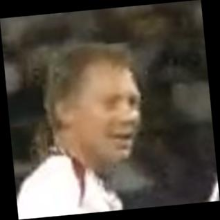

In [ ]:
prediction = model2.predict(x = results[1000:1001],batch_size=1)
predicted_label = int(np.argmax(prediction))
true_label = results_label_int[1000]
print('predicted_label : ', label_mapping[predicted_label])
print('true_label      : ', label_mapping[true_label])

from google.colab.patches import cv2_imshow
cv2_imshow(x_val[152])
